# Time Series Prediction with LSTM Using PyTorch

## Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

## Part I: Atlanta Violent Crime

In [2]:
df = pd.read_csv('atl_violent_final_v2.csv').rename(columns={"Unnamed: 0": "Date", 
                                                                    "occurance_count": "Crime"})
df

,Date,Crime
0,1/1/2009,17
1,1/2/2009,15
2,1/3/2009,23
3,1/4/2009,23
4,1/5/2009,13
...,...,...
4378,12/27/2020,11
4379,12/28/2020,8
4380,12/29/2020,7
4381,12/30/2020,13


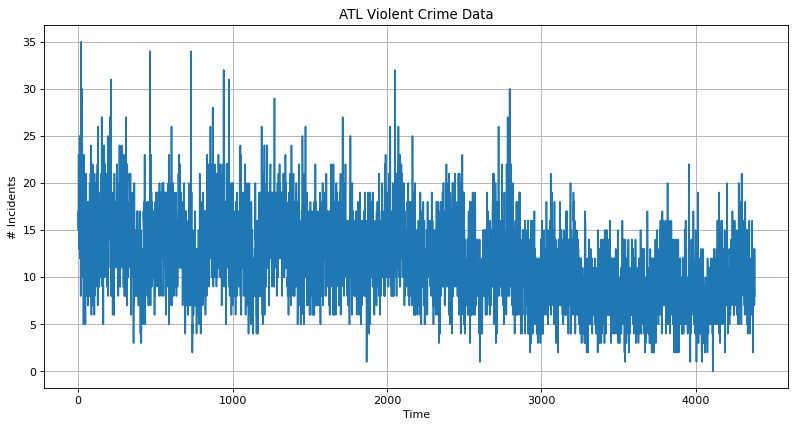

In [3]:
training_set = df.iloc[:,1:2].values

plt.figure(figsize=(12, 6), dpi=80)

plt.plot(training_set)
plt.grid(True)
plt.ylabel('# Incidents')
plt.xlabel('Time')
plt.title('ATL Violent Crime Data')
plt.show()

## Dataloading

In [4]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 7
x, y = sliding_windows(training_data, seq_length)

test_size = 7                  #len(y) - train_size
train_size = len(y) - test_size #int(len(y) * 0.67)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [5]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [18]:
num_epochs = 300
learning_rate = 0.001

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

training_loss = []

# Train the model
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    
    training_loss.append(loss.item())
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.04154
Epoch: 50, loss: 0.02112
Epoch: 100, loss: 0.01659
Epoch: 150, loss: 0.01626
Epoch: 200, loss: 0.01620
Epoch: 250, loss: 0.01612


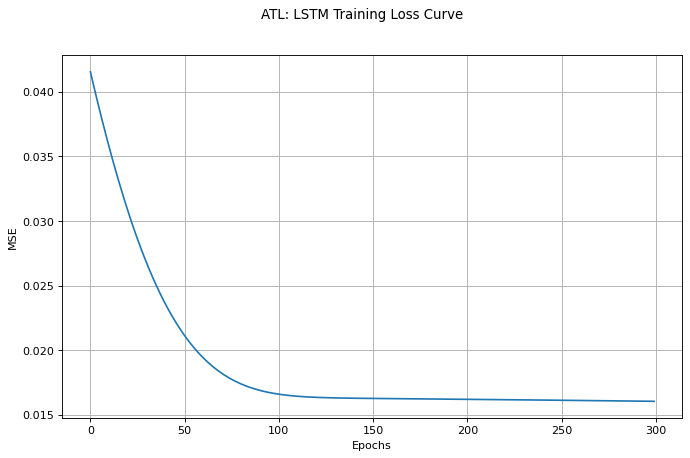

In [20]:
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(training_loss)
plt.suptitle('ATL: LSTM Training Loss Curve')
plt.grid(True)
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

## Model Prediction & Forecasting

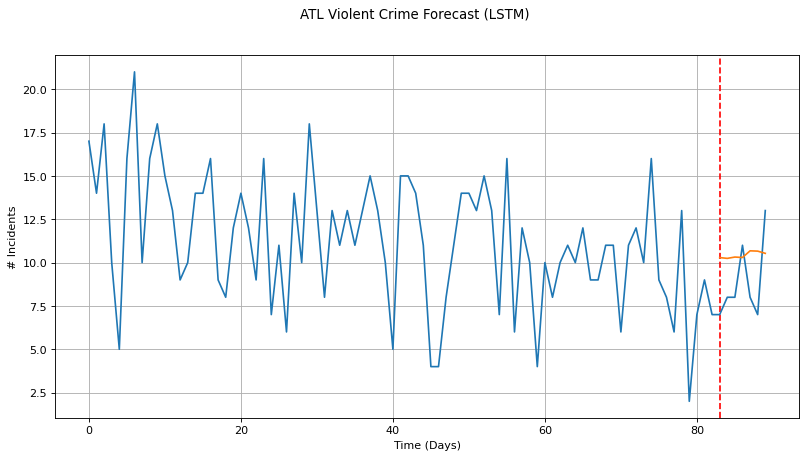

In [14]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(12, 6), dpi=80)

size = 90
plt.axvline(x=size-test_size, c='r', linestyle='--')

x = np.arange(size-test_size, size, 1)

plt.plot(dataY_plot[-size:])
plt.plot(x, data_predict[-test_size:])
plt.suptitle('ATL Violent Crime Forecast (LSTM)')
plt.grid(True)
plt.ylabel('# Incidents')
plt.xlabel('Time (Days)')
plt.show()

## Model Evaluation

In [15]:
def mape(y_true, y_pred):
    temp = [abs(y_true[i]-y_pred[i])/y_true[i] for i in range(len(y_true)) if y_true[i] != 0]
    return np.mean(temp)

def pm(y_true, y_pred):
    return sum((y_true-y_pred)**2)/sum((y_true-np.mean(y_true))**2)

n = len(dataY_plot)
y_true = dataY_plot.reshape(n, )
y_pred = data_predict.reshape(n, )

mape = mape(y_true, y_pred)
pm = pm(y_true, y_pred)

print("==== Training Evaluation Metrics ====")
print("MAPE: {:.3f} \nPM:   {:.3f}".format(mape, pm))

==== Training Evaluation Metrics ====
MAPE: 0.378 
PM:   0.860


In [16]:
mape_test = np.mean(abs(y_true[train_size:len(y)]-y_pred[train_size:len(y)])/y_true[train_size:len(y)])
pm_test = sum((y_true[train_size:len(y)]-y_pred[train_size:len(y)])**2)/sum((y_true[train_size:len(y)]-np.mean(y_true[train_size:len(y)]))**2)

print("==== Test Evaluation Metrics ====")
print("MAPE: {:.3f} \nPM:   {:.3f}".format(mape_test, pm_test))

==== Test Evaluation Metrics ====
MAPE: 0.307 
PM:   1.568


## Part II: NYC Violent Crime

In [21]:
df = pd.read_csv('nyc_violent_final_v3.csv').rename(columns={"Unnamed: 0": "Date", 
                                                                    "occurance_count": "Crime"})
df

,Date,Crime
0,1/1/2009,214
1,1/2/2009,214
2,1/3/2009,262
3,1/4/2009,203
4,1/5/2009,220
...,...,...
4378,12/27/2020,196
4379,12/28/2020,185
4380,12/29/2020,166
4381,12/30/2020,209


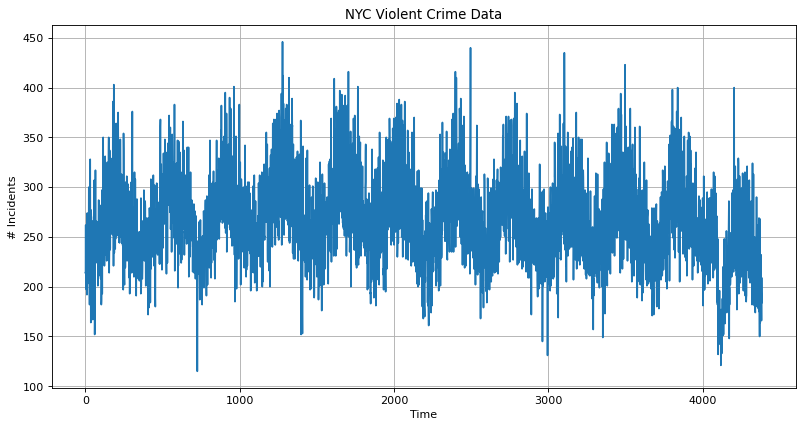

In [22]:
training_set = df.iloc[:,1:2].values

plt.figure(figsize=(12, 6), dpi=80)

plt.plot(training_set)
plt.grid(True)
plt.ylabel('# Incidents')
plt.xlabel('Time')
plt.title('NYC Violent Crime Data')
plt.show()

In [23]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

sc = MinMaxScaler()
training_data = sc.fit_transform(training_set)

seq_length = 7
x, y = sliding_windows(training_data, seq_length)

test_size = 7                  #len(y) - train_size
train_size = len(y) - test_size #int(len(y) * 0.67)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

## Model

In [24]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

## Training

In [28]:
num_epochs = 300
learning_rate = 0.001

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
training_loss = []
for epoch in range(num_epochs):
    outputs = lstm(trainX)
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY)
    
    loss.backward()
    
    optimizer.step()
    
    training_loss.append(loss.item())
    if epoch % 50 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.14656
Epoch: 50, loss: 0.06237
Epoch: 100, loss: 0.03325
Epoch: 150, loss: 0.02313
Epoch: 200, loss: 0.01969
Epoch: 250, loss: 0.01860


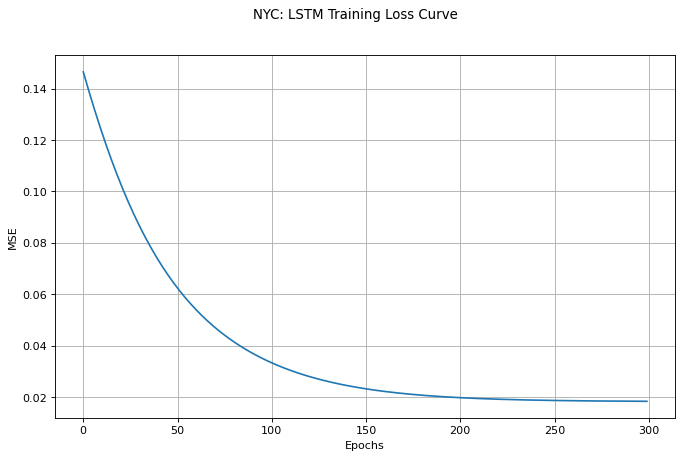

In [29]:
plt.figure(figsize=(10, 6), dpi=80)
plt.plot(training_loss)
plt.suptitle('NYC: LSTM Training Loss Curve')
plt.grid(True)
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.show()

## Model Evaluation

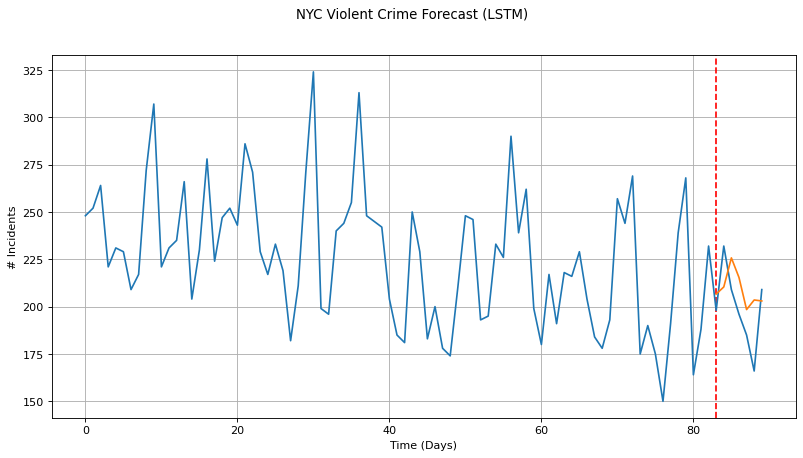

In [208]:
lstm.eval()
train_predict = lstm(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)


plt.figure(figsize=(12, 6), dpi=80)

size = 90
plt.axvline(x=size-test_size, c='r', linestyle='--')

x = np.arange(size-test_size, size, 1)

plt.plot(dataY_plot[-size:])
plt.plot(x, data_predict[-test_size:])
plt.suptitle('NYC Violent Crime Forecast (LSTM)')
plt.grid(True)
plt.ylabel('# Incidents')
plt.xlabel('Time (Days)')
plt.show()

## Model Evaluation

In [209]:
def mape(y_true, y_pred):
    temp = [abs(y_true[i]-y_pred[i])/y_true[i] for i in range(len(y_true)) if y_true[i] != 0]
    return np.mean(temp)

def pm(y_true, y_pred):
    return sum((y_true-y_pred)**2)/sum((y_true-np.mean(y_true))**2)

n = len(dataY_plot)
y_true = dataY_plot.reshape(n, )
y_pred = data_predict.reshape(n, )

mape = mape(y_true, y_pred)
pm = pm(y_true, y_pred)

print("==== Training Evaluation Metrics ====")
print("MAPE: {:.3f} \nPM:   {:.3f}".format(mape, pm))

==== Training Evaluation Metrics ====
MAPE: 0.101 
PM:   0.583


In [210]:
mape_test = np.mean(abs(y_true[train_size:len(y)]-y_pred[train_size:len(y)])/y_true[train_size:len(y)])
pm_test = sum((y_true[train_size:len(y)]-y_pred[train_size:len(y)])**2)/sum((y_true[train_size:len(y)]-np.mean(y_true[train_size:len(y)]))**2)

print("==== Test Evaluation Metrics ====")
print("MAPE: {:.3f} \nPM:   {:.3f}".format(mape_test, pm_test))

==== Test Evaluation Metrics ====
MAPE: 0.092 
PM:   1.093
